<div align="center">

# Individual Project
# Vectorization of the Bronchial Tree Based on CT Imaging  
### Author: Stanisław Dutkiewicz  
### Date: August 4, 2025  

</div>
 

---

## Project Objective

The objective of this project is to obtain a complete and as accurate as possible segmentation of the bronchial tree from computed tomography (CT) data, based on the analysis of HU (Hounsfield Units) values. This is followed by skeletonization of this segmentation and building a graph representing the topology of the tree with nodes at bifurcation points and branch endpoints.

The data comes from CT scans in DICOM format and is analyzed after conversion to HU units in the range from -1000 to +1000.

---

## Introduction

### HU Values Used for Segmentation

Segmentation of anatomical structures was performed based on thresholds in the Hounsfield (HU) scale and 3D morphological operations. Intensity ranges were assigned to specific tissue types:

- **Air / Bronchial Tree**: < –850 HU  
- **Soft Tissues (e.g., Blood Vessels)**: from –500 to +400 HU  
- **Bone / Contrast Materials**: > +400 HU (omitted in this project)

As a result of segmentation, a binary mask was obtained, which served as the basis for further processing, including **skeletonization**, consisting in obtaining a one-voxel representation of the topology of the bronchial tree.


#### Installation of Required Libraries

In [1]:
import subprocess
import sys

# Lista pakietów do instalacji
packages = [
    "numpy",
    "matplotlib",
    "scikit-image",
    "scipy",
    "pydicom",
    "nibabel",
    "pyvista[jupyter]",
    "trame",
    "trame-vuetify",
    "trame-vtk"
]


module_alias = {
    "scikit-image": "skimage",
    "pyvista[jupyter]": "pyvista",
    "trame-vuetify": "trame",
    "trame-vtk": "trame"
}

for pkg in packages:
    module_name = module_alias.get(pkg, pkg.split("[")[0].split("-")[0]) # wyciąganie nazwy modułu z pakietu
    
    try:
        __import__(module_name)
        print(f"{pkg} OK")
    except ImportError:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--user"])


numpy OK
matplotlib OK
matplotlib OK


c:\Users\stand\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


scikit-image OK
scipy OK
pydicom OK
pydicom OK
nibabel OK
nibabel OK
pyvista[jupyter] OK
trame OK
trame-vuetify OK
trame-vtk OK
pyvista[jupyter] OK
trame OK
trame-vuetify OK
trame-vtk OK


#### Importing Libraries

In [2]:

import os  


import numpy as np  # obliczenia macierzowe, operacje na tablicach
import matplotlib.pyplot as plt  # wizualizacja danych 2D


from skimage import measure, morphology  # analiza regionów, operacje morfologiczne
from skimage.morphology import ball, binary_closing, remove_small_objects, skeletonize  # konkretne operacje morfologiczne
from skimage.measure import label, regionprops  # etykietowanie i analiza obiektów

import pydicom  # odczyt plików DICOM (obrazy z tomografii komputerowej)
import nibabel as nib  # obsługa plików NIfTI (obrazy medyczne 3D)


from scipy.spatial import cKDTree  # szybkie wyszukiwanie sąsiadów w przestrzeni 3D


from scipy.ndimage import binary_fill_holes, binary_dilation  # operacje na obrazach binarnych


import pyvista as pv  # wizualizacja obiektów 3D (maski, siatki, punkty)


---

## Table of Contents
- [Stage 1: Loading Data and Converting to HU](#stage-1-loading-data-and-converting-to-hu)
- [Stage 2: Lung Segmentation and Tissue Analysis](#stage-2-lung-segmentation-and-tissue-analysis)
- [Stage 3: Bronchial Tree Segmentation](#stage-3-bronchial-tree-segmentation)
- [Stage 4: Skeletonization of the Bronchial Tree](#stage-4-skeletonization-of-the-bronchial-tree)
- [Stage 5: Visualization and Brief Analysis and Comparison with Lung Skeleton](#stage-5-visualization-and-brief-analysis-and-comparison-with-lung-skeleton)
- [Conclusions](#conclusions)
---

### Stage 1: Loading Data and Converting to HU

In the first stage of the project, we process raw tomographic data in DICOM format. These data contain pixels in arbitrary units, which must be converted to physical values on the Hounsfield (HU) scale. The HU scale allows tissue differentiation based on their density – air has a value of approximately -1000 HU, water 0 HU, and soft and bone tissues have positive values.

After conversion, we perform preliminary lung segmentation based on HU value thresholding. For a simplified model, we assume that the lungs are areas with HU lower than -320.

Additionally, we apply data windowing, i.e., clipping HU values to the range [-1000, 400], which improves image readability during visualization.

As a result of this stage, we obtain:
- cross-sectional images of CT scans in different processing phases (raw, after windowing),
- a lung mask overlaid on images,
- a histogram of HU values within identified lungs.

#### Functions Used in This Stage:

- `load_dicom_series(folder_path)` – A function that loads a series of DICOM images from a given folder. Images are sorted by position on the Z axis to maintain correct spatial order.

- `convert_to_hounsfield(slices)` – A function that converts raw pixel data to physical Hounsfield Units (HU), used in medicine to differentiate tissues based on their density.

- `clip_to_window(image, min_hu, max_hu)` – A function that limits (clips) values in a CT image to a given HU range (for analysis).

#### Procedure:

1. A series of DICOM images from a directory was loaded using the `load_dicom_series()` function.
2. Raw pixel data was converted to the Hounsfield scale using `convert_to_hounsfield()`.
3. Data windowing was applied in the range [-1000, 400] HU using `clip_to_window()`.
4. Three representative cross-sectional CT images in grayscale were visualized.
5. The distribution of HU values and correctness of data conversion were analyzed.

#### Code for Described Functions

In [3]:
def load_dicom_series(directory):
    """Wczytuje serię obrazów DICOM z podanego katalogu."""
    slices = []
    for filename in sorted(os.listdir(directory)):
        
        path = os.path.join(directory, filename)
        ds = pydicom.dcmread(path)
        slices.append(ds)

    if not slices:
        raise ValueError("Nie znaleziono żadnych plików DICOM.")

    # Sortowanie po pozycji Z
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

def convert_to_hounsfield(slices):
    """Konwertuje serię obrazów DICOM do skali Hounsfielda (HU)."""
    image = np.stack([s.pixel_array for s in slices])
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    return image.astype(np.int16) * slope + intercept

def clip_to_window(image, min_hu=-1000, max_hu=400):
    """Ogranicza wartości w obrazie CT do zadanego zakresu HU."""
    return np.clip(image, min_hu, max_hu)



#### Function Calling and Data Processing

Note: Make sure that the folder with DICOM files is in the same location as this notebook. In my case, the files come from Microsoft Teams (GE224 → Medical Projects → CT).

In [4]:
dicom_path = "Z76102888" # Nazwa katalogu z plikami DICOM

slices = load_dicom_series(dicom_path) 
image_hu = convert_to_hounsfield(slices)
windowed_hu = clip_to_window(image_hu, min_hu=-1000, max_hu=400)

#### Visualization of Processed Data

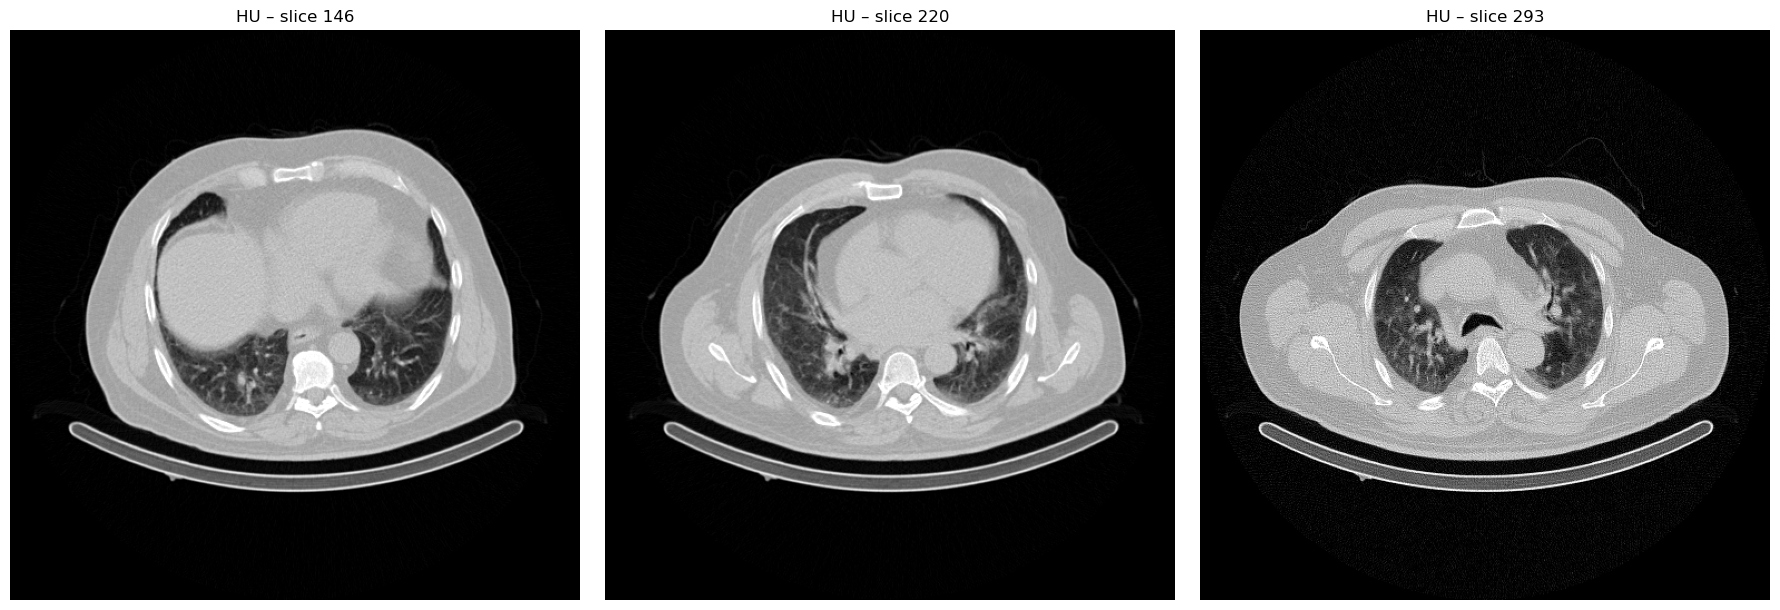

In [5]:
indices = [image_hu.shape[0] // 3, image_hu.shape[0] // 2, 2 * image_hu.shape[0] // 3]  # Wybór trzech indeksów do wyświetlenia

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 wiersz, 3 kolumny

for col, idx in enumerate(indices):
    axes[col].imshow(windowed_hu[idx], cmap='gray', vmin=-1000, vmax=400)
    axes[col].set_title(f"HU – slice {idx}")
    axes[col].axis('off')

plt.tight_layout()
plt.show()


In the presented CT cross-sections, the lower, middle, and upper parts of the chest are visible – including the lungs, heart, and trachea. Applying the window [-1000, 400] HU made it possible to clearly distinguish air-filled lung spaces from soft tissues. This made structures such as bronchi and lung boundaries more visible. The HU scale allows for clear anatomical analysis and possible pathological changes in the images.

---
### Stage 2: Lung Segmentation and Tissue Analysis

In the second stage, we perform proper lung segmentation based on CT imaging converted to the Hounsfield (HU) scale. This segmentation is based on the extraction of areas corresponding to lungs – these are air-filled spaces and surrounding soft tissues, whose HU values typically fall in the range from approximately -950 to -300 HU.

For segmentation, we use morphological operations such as closing and removal of small objects, which allows us to obtain a clean lung mask, free of artifacts and connections with other anatomical structures.

On the obtained lung mask, we perform an analysis of the distribution of HU values by creating a histogram covering only the lung area, which allows better understanding of what types of tissues are present within them.

As a result of this stage, we obtain:
- a binary mask segmenting both lungs based on HU values and anatomical shape,
- a cleaned mask free of artifacts and connections with other structures,
- cross-sectional images of CT scans with an overlaid lung mask,
- a histogram of the distribution of HU values within the lungs, used to analyze tissue content.

#### Functions Used in This Stage:

- `segment_lungs(image_hu)`: Performs lung segmentation, combining threshold masking, cleaning, and artifact removal from the bottom.
- `clean_lung_mask(binary_mask, min_size)`: Cleans the binary lung mask, leaving the largest areas corresponding to the lungs.
- `remove_bottom_artifacts(mask, cutoff_ratio)`: Removes the bottom part of the mask (e.g., artifacts below the diaphragm).

#### Procedure:

1. The `segment_lungs(image_hu)` function was called to obtain a binary lung mask.
2. Cross-sections were visualized, showing both the CT image and the lung mask.
3. Based on the lung mask, a histogram of HU values was generated only for the interior of the lungs, allowing tissue distribution analysis.

#### Code for Described Functions:

In [6]:
def clean_lung_mask(binary_mask, min_size=1500):
    """Czyści maskę płuc: usuwa małe obiekty, zostawia największe płuca."""
    cleaned = morphology.remove_small_objects(binary_mask, min_size=min_size)
    labeled = measure.label(cleaned) # Etykietowanie obiektów w masce
    regions = measure.regionprops(labeled) # Pobieranie właściwości regionów
    
    # Usuwanie małych obiektów, pozostawiając tylko największe płuca
    if len(regions) > 0: 
        areas = sorted([r.area for r in regions], reverse=True)
        threshold = areas[1] * 0.5 if len(areas) >= 2 else areas[0] * 0.1
        cleaned = morphology.remove_small_objects(labeled, min_size=threshold)
    
    return cleaned > 0

def remove_bottom_artifacts(mask, cutoff_ratio=0.9):
    """Usuwa dolną część maski poniżej cutoff_ratio"""
    h = mask.shape[1]
    cutoff = int(h * cutoff_ratio)
    mask[:, cutoff:, :] = False
    return mask

def segment_lungs(image_hu, min_size=1000):
    """Pełna segmentacja płuc: HU maskowanie + cleaning + usuwanie artefaktów."""
    rough_mask = (image_hu >= -1000) & (image_hu <= -400)
    body_mask = image_hu > -800
    initial_mask = rough_mask & body_mask

    cleaned_mask = clean_lung_mask(initial_mask, min_size)
    cleaned_mask = remove_bottom_artifacts(cleaned_mask, cutoff_ratio=0.69)
    cleaned_mask = morphology.remove_small_objects(cleaned_mask, min_size=500)
    
    
    return cleaned_mask

#### Function Calling and Data Processing

In [7]:
lung_mask = segment_lungs(image_hu)

#### Visualization of Sample Cross-Sections with Overlaid Lung Mask

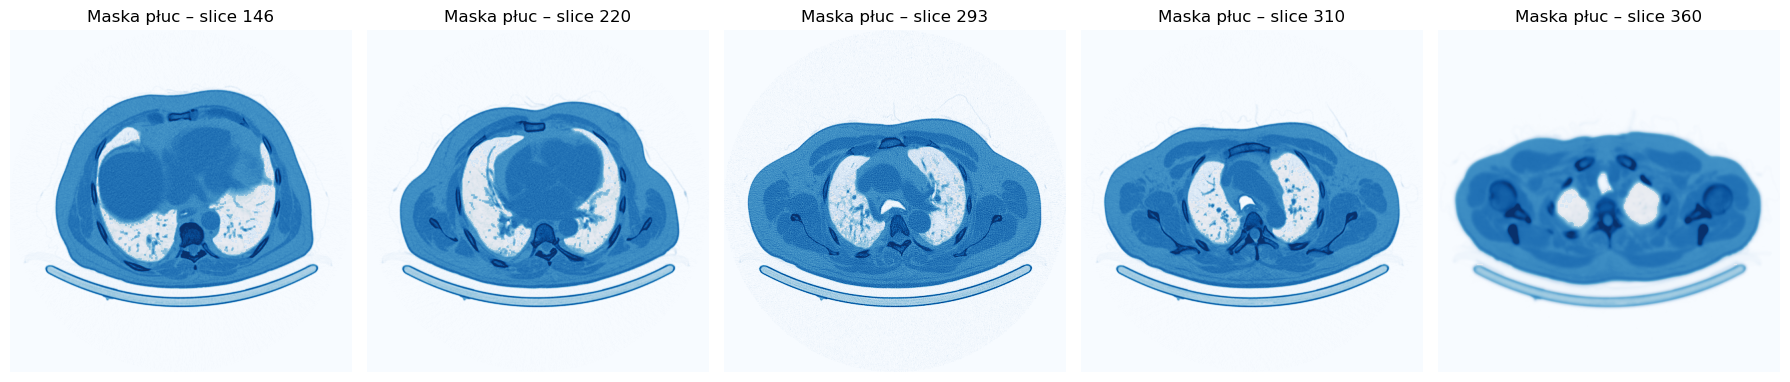

In [8]:
indices = [image_hu.shape[0] // 3, image_hu.shape[0] // 2, 2 * image_hu.shape[0] // 3, 310, 360]

fig, axes = plt.subplots(1, 5, figsize=(18, 6))

for ax, idx in zip(axes, indices):
    ax.imshow(windowed_hu[idx], cmap='Blues', vmin=-1000, vmax=400)
    overlay = np.ma.masked_where(~lung_mask[idx], lung_mask[idx])
    ax.imshow(overlay, cmap='Reds', alpha=0.5)
    ax.set_title(f"Maska płuc – slice {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()



In the above cross-sections, we see the results of lung segmentation at different heights of the chest: in the lower, middle, and upper parts. The lung mask was successfully overlaid on the CT image and precisely separates air spaces from soft tissues and chest walls. In lower cross-sections, the lungs are more differentiated in terms of internal structures, while in the upper sections, larger bronchi and tracheal bifurcation are clearly outlined. The mask also includes the trachea. The segmentation preserves anatomical symmetry and does not show extensions beyond the lung area. Areas belonging to the lung mask are marked in white, which allows easy identification of anatomical structures against the background of the raw CT image displayed in shades of blue.

#### Histogram of HU Values Within Lung Masks

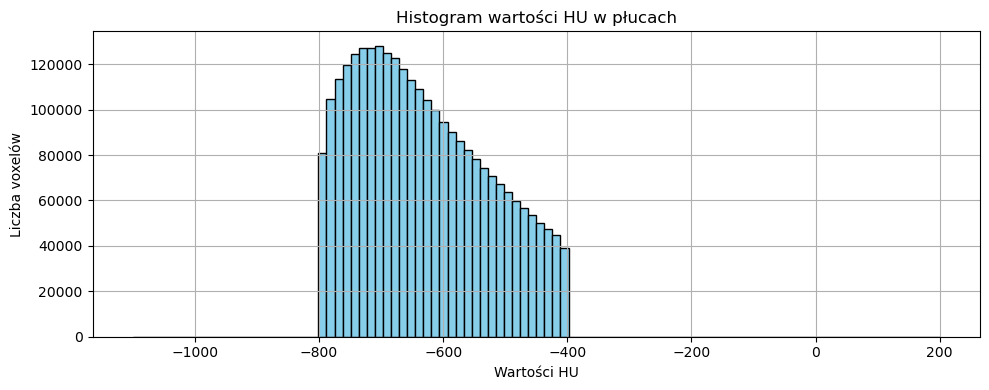

In [9]:
plt.figure(figsize=(10, 4))
plt.hist(image_hu[lung_mask].ravel(), bins=100, range=(-1100, 200), color='skyblue', edgecolor='black')
plt.title("Histogram wartości HU w płucach")
plt.xlabel("Wartości HU")
plt.ylabel("Liczba voxelów")
plt.grid(True)
plt.tight_layout()
plt.show()


The histogram shows the distribution of Hounsfield (HU) units within the segmented lung mask. The highest concentration of voxels falls in the range from approximately -800 to -600 HU, which corresponds to air-filled alveolar spaces, typical for healthy lung tissue. Values above -600 HU indicate the presence of denser structures, such as bronchi, blood vessels, or possible pathologies (e.g., fibrosis, inflammation). The histogram uses light blue bars with black edges. The results confirm the correctness of the segmentation. The range of values is consistent with the physiological distribution of tissues within the lungs, without the presence of extreme deviations characteristic of tissues outside the respiratory system.

### Stage 3: Bronchial Tree Segmentation

In the third stage, we perform detailed segmentation of the bronchial tree also using the Hounsfield scale. The aim is to extract both large airway structures (trachea and main bronchi) and thin branches extending deep into the lungs.

This stage consumed the most time in this project.

The process begins with air segmentation using the HU threshold < -850 and morphological closing operations. Then we expand the obtained air mask and search for the so-called "bronchial walls" – areas with HU density between -500 and 200, which are adjacent to air channels.

For the obtained bronchi contour, we perform hole filling, cleaning small structures, and removing unwanted artifacts from the upper and lower parts of the chest.

Additionally, thin, elongated structures located close to the main airway mask are searched for (e.g., lateral branches). Selection conditions include, among others: length, elongation, and distance from the main tree.

Finally, we expand the mask with a so-called "shell" – an additional layer around existing bronchi, especially in the bifurcation area, to account for adjacent wall tissues.

As a result of this stage, we obtain:
- a mask segmenting the airways (main and secondary branches),
- cleaning and morphological closure of the structure,
- local expansions (shell, lateral branches),
- information about the number of voxels in the final airway mask

#### Libraries Used in This Stage:

- **scikit-image** (`skimage.morphology`, `skimage.measure`) – morphological operations (`binary_closing`, `binary_dilation`, `ball`, `remove_small_objects`, `skeletonize`), object labeling (`label`, `regionprops`), removal of small components
- **scipy.ndimage** – operations on binary images (`binary_fill_holes`, `binary_dilation`), advanced 3D structure processing
- **scipy.spatial** – data structure (`cKDTree`) for fast nearest neighbor search in 3D space (method `query`), key for identifying thin bronchi branches
- **numpy** – array operations (`argwhere`, `zeros_like`, `copy`) and basic arithmetic operations on voxels

#### Functions Used in This Stage:

- `segment_airways(image_hu)`: Main function performing segmentation of the entire bronchial tree based on the HU image.

- `remove_top_and_bottom(mask, cutoff_top_ratio, cutoff_bottom_ratio)`: Removes artifacts from the upper and lower regions of the mask. The cutoff parameters were selected to cut off fragments outside the chest, while preserving essential structures in the middle of the imaging range.

- `binary_closing(...)`, `binary_fill_holes(...)`, `remove_small_objects(...)`: Morphological operations cleaning the mask of erroneous fragments.

- `find_additional_airway_branches_near_existing_mask(...)`: Searches for thin, elongated bronchi branches adjacent to the main mask. Parameters such as HU range (-940 to -550) allow extraction of air-filled branches, max_dist=12 limits detection to structures close to the main mask, elongation_thresh=1 ensures selection of elongated shapes, and min_voxels=5, max_voxels=2000, and max_bbox_dim=40 eliminate noise and oversized artifacts, leaving only anatomically realistic branches.

- `add_shell_to_airway_mask(...)`: Expands the airway mask with an additional layer in the bifurcation area (shell) to improve mask completeness. Parameters such as HU range (-480 to 200) and shell width (1) were selected to cover a thin layer of wall tissue around bronchi, especially in the bifurcation area. Increasing the mask thickness in a specified cross-section range (bifurcation_range) allows better representation of the complex anatomy of branching.

- `segment_lungs(image_hu)`: This function is used in this case to limit the search area only to the inside of the chest cavity.

#### Procedure:

1. The `segment_airways(image_hu)` function was called to perform comprehensive airway segmentation.
2. The process began with air segmentation using the HU threshold < -850 and morphological operations.
3. The air mask was expanded and bronchial walls in the HU range [-500, 200] were extracted.
4. Holes in the mask were filled and small objects and artifacts from the upper and lower parts of the image were removed.
5. Additional thin bronchi branches were searched for using geometric and distance criteria.
6. A coating (shell) was added around existing structures, especially in the tracheal bifurcation area.
7. The segmentation results were visualized on cross-sections and as a GIF animation.
8. The number of segmented voxels and quality of the obtained airway mask were analyzed.

#### Code for Described Functions

In [10]:
def remove_top_and_bottom(mask, cutoff_top_ratio=0.1, cutoff_bottom_ratio=0.9):
    """Removes both the top and bottom parts of the mask along the Y axis."""
    h = mask.shape[1]
    top_cutoff = int(h * cutoff_top_ratio)
    bottom_cutoff = int(h * cutoff_bottom_ratio)

    mask[:, :top_cutoff, :] = False # remove top part of mask
    mask[:, bottom_cutoff:, :] = False # remove bottom part of mask

    return mask



def clean_lung_mask(binary_mask, min_size=1500):
    """Cleans lung mask: removes small objects, keeps the largest lungs."""
    cleaned = morphology.remove_small_objects(binary_mask, min_size=min_size)
    labeled = measure.label(cleaned)
    regions = measure.regionprops(labeled)
    

    # Remove small objects, keeping only the largest lungs
    if regions:
        areas = sorted([r.area for r in regions], reverse=True) 
        threshold = areas[1] * 0.5 if len(areas) >= 2 else areas[0] * 0.1 # determine threshold
        cleaned = morphology.remove_small_objects(labeled, min_size=threshold)
    
    return cleaned > 0



def segment_lungs(image_hu, min_size=1000):
    """Full lung segmentation: HU masking + cleaning + artifact removal."""

    # HU-based masking
    rough_mask = (image_hu >= -1000) & (image_hu <= -400)
    body_mask = image_hu > -800

    # Initial lung mask
    initial_mask = rough_mask & body_mask

    cleaned_mask = clean_lung_mask(initial_mask, min_size)
    cleaned_mask = remove_top_and_bottom(cleaned_mask, cutoff_top_ratio=0.0, cutoff_bottom_ratio=0.69)
    cleaned_mask = morphology.remove_small_objects(cleaned_mask, min_size=500)
    
    
    return cleaned_mask


def add_shell_to_airway_mask(airway_mask, image_hu, hu_min, hu_max, shell_width, bifurcation_range, bifurcation_boost=2):
    """Adds a shell around the airway_mask — globally and thicker locally in the bifurcation."""
    
    z_start, z_end = bifurcation_range # Z-axis range for bifurcation

    # Base shell
    dilated = binary_dilation(airway_mask, structure=ball(shell_width))

    # Additional expansion only for bifurcation
    boost_dilated = np.zeros_like(airway_mask, dtype=bool)
    boost_region = np.zeros_like(airway_mask, dtype=bool)
    boost_region[z_start:z_end] = airway_mask[z_start:z_end]
    boost_dilated = binary_dilation(boost_region, structure=ball(bifurcation_boost))

    
    shell = (dilated | boost_dilated) & (~airway_mask)

    # Only in HU range for bronchial walls
    shell = shell & ((image_hu >= hu_min) & (image_hu <= hu_max))

    return airway_mask | shell


def find_additional_airway_branches_near_existing_mask(image_hu, airway_mask, lung_mask,hu_min, hu_max, max_dist, elongation_thresh, min_voxels, 
        max_voxels, max_bbox_dim):
    """Searches for thin, elongated structures inside the lungs near the existing airway mask"""
    
    # Candidate search for thin branches
    candidate_mask = (image_hu >= hu_min) & (image_hu <= hu_max)
    candidate_mask &= lung_mask & (~airway_mask)

    labeled = label(candidate_mask)
    props = regionprops(labeled)

    # Filter candidates by size and shape
    airway_coords = np.argwhere(airway_mask)
    airway_tree = cKDTree(airway_coords)

    # Initialize result mask
    result_mask = np.zeros_like(airway_mask, dtype=bool)
    added = 0

    for p in props:
        if not (min_voxels <= p.area <= max_voxels):
            continue
        
        # Determine component dimensions
        z0, y0, x0, z1, y1, x1 = *p.bbox[0:3], *p.bbox[3:6]  
        dz, dy, dx = z1 - z0, y1 - y0, x1 - x0
        max_dim = max(dz, dy, dx)
        min_dim = max(1, min(dz, dy, dx))
        elongation = max_dim / min_dim

        if max_dim > max_bbox_dim:
            continue  # component too large (e.g., half lung)

        if elongation < elongation_thresh:
            continue  # not elongated enough

        centroid = np.array(p.centroid) # component centroid
        dist, _ = airway_tree.query(centroid) # nearest point search in airway mask

        if dist > max_dist:
            continue # too far from existing airway mask

        result_mask[tuple(p.coords.T)] = 1 # add to result mask
        
        added += 1 # counter


    print(f"Added {added} thin branches (after filtering).")
    return result_mask

# ------------------------------------------------------------
# MAIN FUNCTION FOR AIRWAY SEGMENTATION
# ------------------------------------------------------------

def segment_airways(image_hu):
    """
    Airway segmentation with extension for deeper and higher branches.
    """    

    # 1. Air segmentation
    air_mask = (image_hu <= -850)
    print("Air voxels:", np.sum(air_mask))
    air_mask = binary_closing(air_mask, footprint=ball(1))


    # 2. Air expansion
    expanded = binary_dilation(air_mask, structure=ball(2), iterations=1)


    # 3. Extract walls
    wall_mask = expanded & ((image_hu >= -500) & (image_hu <= 200))
    
    print("After HU clipping [-500, 200]:", np.sum(wall_mask))

    # 4. Fill holes
    for z in range(wall_mask.shape[0]):
        wall_mask[z] = binary_fill_holes(wall_mask[z])

    # Remove small objects
    wall_mask = remove_small_objects(wall_mask, min_size=3)

    
    # 5. Remove top and bottom artifacts
    wall_mask = remove_top_and_bottom(wall_mask, cutoff_top_ratio=0.35, cutoff_bottom_ratio=0.63)


    lung_mask = segment_lungs(image_hu)

    # 6. Additional expansions
    thin_branches = find_additional_airway_branches_near_existing_mask(
    image_hu=image_hu,
    airway_mask=wall_mask,
    lung_mask=lung_mask, 
    hu_min=-940,
    hu_max=-550,
    max_dist=12,
    elongation_thresh=1,
    min_voxels=5,
    max_voxels=2000,
    max_bbox_dim=40,
    )
    wall_mask |= thin_branches
    

    wall_mask = add_shell_to_airway_mask(
    airway_mask=wall_mask,
    image_hu=image_hu,
    hu_min=-480,
    hu_max=200,
    shell_width=1,
    bifurcation_range=(90, 110),     
    bifurcation_boost=2              
    )

    print("Final number of voxels in airway mask:", np.sum(wall_mask))
    return wall_mask


#### Function Calling

In [11]:
airway_mask = segment_airways(image_hu)

Air voxels: 71470226
After HU clipping [-500, 200]: 1247105
After HU clipping [-500, 200]: 1247105
Added 205 thin branches (after filtering).
Added 205 thin branches (after filtering).
Final number of voxels in airway mask: 620858
Final number of voxels in airway mask: 620858


#### Visualization

##### Images

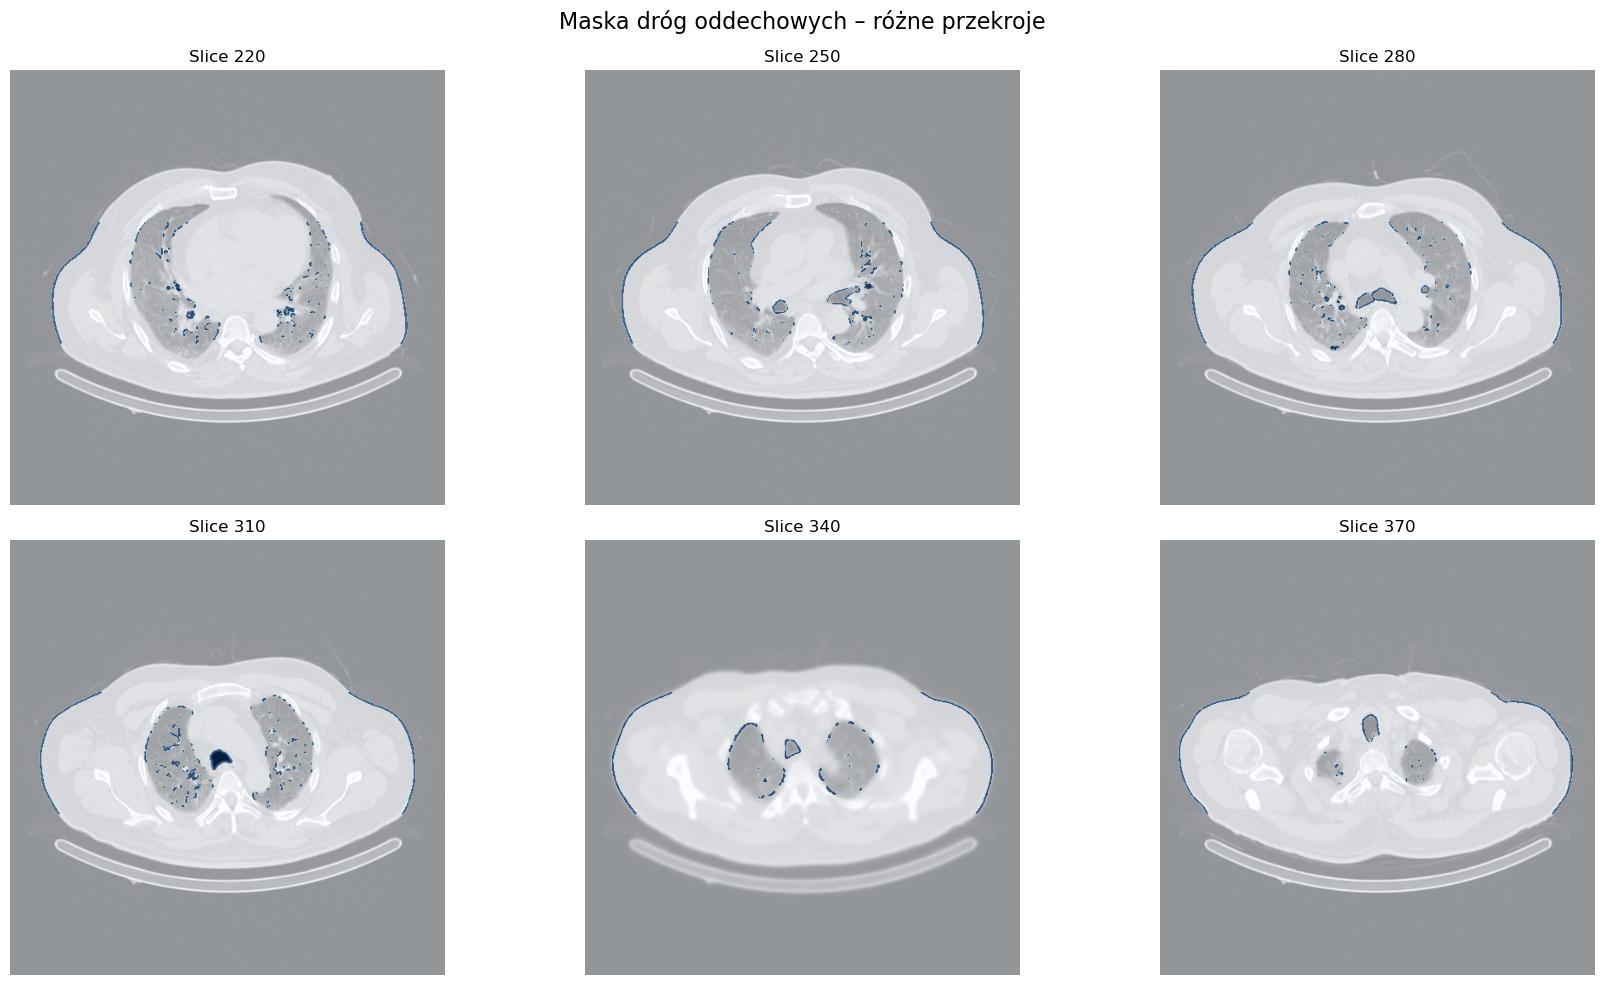

In [12]:
import matplotlib.pyplot as plt

start_index = image_hu.shape[0] // 2
end_index = start_index + 150
step = (end_index - start_index) // 5  # 6 obrazków = 5 kroków

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i in range(6):
    idx = start_index + i * step
    ax = axs[i // 3, i % 3]
    ax.imshow(image_hu[idx], cmap='gray', vmin=-1000, vmax=400)
    ax.imshow(airway_mask[idx], cmap='Blues', alpha=0.6)
    ax.set_title(f"Slice {idx}")
    ax.axis('off')

plt.suptitle("Maska dróg oddechowych – różne przekroje", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


The presented cross-sections show the result of airway segmentation obtained in the third stage. Visible are the bifurcations of the bronchial tree in various lung areas, represented by dark blue structures on the background of CT images. The airway mask was overlaid on the raw data and includes both main bronchial walls and thinner, more distal branches. The gradually changing shape and position of the branches reflect the natural branching of the trachea deep into the lungs. The results confirm the effectiveness of the applied methods in separating air structures from surrounding tissues – while maintaining continuity and morphology of bronchi, especially in their distal sections.

However, there are also visible dark blue dots in the areas around lung boundaries, especially near blood vessels, which were included in the mask due to HU values falling within the specified range. These elements will be removed in the skeletonization stage, which will preserve only the central axes of proper air structures.

#### GIF

C:\Users\stand\AppData\Local\Temp\ipykernel_28544\3859891639.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


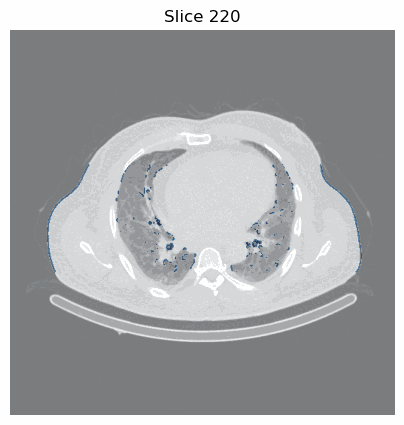

In [13]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image, display

# Folder tymczasowy
os.makedirs("temp_gif_frames", exist_ok=True)

# Zakres slice’ów
start = image_hu.shape[0] // 2
end = start + 130

filenames = []

for i, idx in enumerate(range(start, end)):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image_hu[idx], cmap='gray', vmin=-1000, vmax=400)
    ax.imshow(airway_mask[idx], cmap='Blues', alpha=0.5)
    ax.set_title(f"Slice {idx}")
    ax.axis('off')

    filename = f"temp_gif_frames/frame_{i:03d}.png"
    plt.savefig(filename, bbox_inches='tight')
    filenames.append(filename)
    plt.close(fig)

# Tworzenie GIF-a
gif_path = "airway_scroll.gif"
with imageio.get_writer(gif_path, mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Usuwanie tymczasowych plików
for filename in filenames:
    os.remove(filename)
os.rmdir("temp_gif_frames")

# Wyświetlenie GIF
display(Image(filename=gif_path))


The above animation shows the visualization of airway masks on successive computed tomography cross-sections. By smoothly transitioning through layers, it is easy to observe the continuity and branching of the bronchial tree deep into the lungs. Airway structures are marked in dark blue, which contrasts well with the light gray background of tissues. This form of presentation makes it easy to analyze segmentation throughout the entire data volume, rather than limiting it to individual cross-sections.

---

### Stage 4: Skeletonization of the Bronchial Tree

In this stage, we perform skeletonization of the previously obtained airway mask. The goal is to obtain a one-voxel skeleton that represents the course of airways in a simplified, topological form. Such a skeleton serves as the basis for further structural analysis and skeleton visualization itself.

As a result of this stage, we obtain:
- a one-voxel skeleton of the bronchial tree (ang. *skeleton*),
- a cleaned version of the skeleton free of artifacts at the volume edges,
- the largest connected component of the skeleton, which represents the main branches of the airways.

#### Functions Used:

- `skeletonize_airways(airway_mask)` Creates a binary skeleton from the airway mask using the `skeletonize` function from the `skimage.morphology` library.

- `remove_voxels_near_edges(skeleton, margin=100)` Removes skeleton voxels located at volume edges (X and Y axes), which are often artifacts unrelated to actual anatomy.

- `extract_largest_skeleton_component(skeleton)` Extracts the largest connected skeleton component, ignoring small, isolated fragments resulting from noise or segmentation errors.

#### Procedure:

1. Skeletonization of the airway mask was performed using the `skeletonize_airways()` function.
2. Simultaneously, skeletonization of the lung mask was performed for comparison purposes.
3. Skeleton voxels located at volume edges (margin of 120 voxels) were removed using `remove_voxels_near_edges()`.
4. The largest connected component of each skeleton was extracted using `extract_largest_skeleton_component()`.
5. The number of voxels before and after skeletonization was counted and compared for both structures.
6. Masks before skeletonization were saved in `NIfTI` format (.nii.gz) for further analysis in `3D Slicer`.
7. The compression ratio (reduction in the number of voxels) after skeletonization was analyzed.

#### Code for Given Functions

In [14]:
def skeletonize_airways(airway_mask):
    """
    Skeletonization of the airway mask.
    """
    skeleton = skeletonize(airway_mask)

    cleaned = np.copy(skeleton)
    
    return cleaned


def remove_voxels_near_edges(skeleton, margin):
    """
    Removes all voxels that are within `margin` distance from the volume boundary along X and Y axes.
    """
    mask = np.zeros_like(skeleton, dtype=bool)

    # margin along X axis
    mask[:, :, :margin] = True
    mask[:, :, -margin:] = True

    # margin along Y axis
    mask[:, :margin, :] = True
    mask[:, -margin:, :] = True

    to_remove = mask & (skeleton == 1)
    cleaned = np.copy(skeleton)
    cleaned[to_remove] = 0

    print(f"Removed {np.sum(to_remove)} skeleton voxels near edges (margin={margin}).")
    return cleaned

def extract_largest_skeleton_component(skeleton):
    """
    Returns the largest (by number of voxels) connected component of the skeleton.
    """
    labeled = label(skeleton)
    props = regionprops(labeled)

    if not props:
        print("No components found in the skeleton.")
        return np.zeros_like(skeleton, dtype=bool)

    # Choose the largest component
    largest = max(props, key=lambda p: p.area)
    largest_mask = np.zeros_like(skeleton, dtype=bool)
    largest_mask[tuple(largest.coords.T)] = True


    return largest_mask

#### Function Calling on Lung and Airway Tree Mask

In [15]:
# Save airway mask before skeletonization, can be opened in 3D Slicer
nib.save(nib.Nifti1Image(airway_mask.astype(np.uint8), np.eye(4)), "output/airway_mask_FI.nii.gz") 

print("Number of voxels in airway tree before skeletonization:", np.sum(airway_mask))
airway_skeleton = skeletonize_airways(airway_mask)
airway_skeleton = remove_voxels_near_edges(airway_skeleton, margin=120)
airway_skeleton = extract_largest_skeleton_component(airway_skeleton)
print("Number of voxels in airway tree after skeletonization:", np.sum(airway_skeleton))

print("\n\n")

print("Number of voxels in lungs before skeletonization:", np.sum(lung_mask))
lung_skeleton = skeletonize_airways(lung_mask)
lung_skeleton = remove_voxels_near_edges(lung_skeleton, margin=120)
lung_skeleton = extract_largest_skeleton_component(lung_skeleton)
print("Number of voxels in lungs after skeletonization:", np.sum(lung_skeleton))

Number of voxels in airway tree before skeletonization: 620858
Removed 26632 skeleton voxels near edges (margin=120).
Removed 26632 skeleton voxels near edges (margin=120).
Number of voxels in airway tree after skeletonization: 11401



Number of voxels in lungs before skeletonization: 2776465
Number of voxels in airway tree after skeletonization: 11401



Number of voxels in lungs before skeletonization: 2776465
Removed 12174 skeleton voxels near edges (margin=120).
Removed 12174 skeleton voxels near edges (margin=120).
Number of voxels in lungs after skeletonization: 1222737
Number of voxels in lungs after skeletonization: 1222737


### Stage 5: Visualization and Brief Analysis and Comparison with Lung Skeleton

In this stage, the goal was to visualize the skeleton of the bronchial tree and lungs in three-dimensional space.

I also decided to export the skeleton to `.vtp` format, where the structure can be deeply loaded and visualized for the user in the **3D Slicer** program

#### Procedure:

1. Bronchial tree and lung skeletons were converted to lists of 3D point coordinates.
2. A 90° rotation of points was applied in the XZ plane so that the trachea was at the top of the visualization.
3. Skeletons were exported to VTP format using the PyVista library for further analysis in medical programs.
4. An analysis of the number of voxels in each skeleton was performed.
5. 3D visualizations of skeletons were created using PyVista 
6. The quality of the obtained skeletons was analyzed in terms of anatomical consistency and spatial limitation to the lung mask.

#### Saving the Skeleton in VTP Format

In [16]:
coords = np.argwhere(airway_skeleton)
cloud = pv.PolyData(coords)
cloud.save("output/airway_skeleton.vtp")

lung_coords = np.argwhere(lung_skeleton)
lung_cloud = pv.PolyData(lung_coords)
lung_cloud.save("output/lung_skeleton.vtp")

c:\Users\stand\anaconda3\Lib\site-packages\pyvista\core\utilities\points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


#### Analysis of the Number of Voxels in Lung and Airway Tree Skeletons

In [17]:
airway_count = np.sum(airway_skeleton)
print(f"Liczba voxelów w szkielecie drzewa oskrzelowego: {airway_count}")

lung_count = np.sum(lung_skeleton)
print(f"Liczba voxelów w szkielecie płuc: {lung_count}")

Liczba voxelów w szkielecie drzewa oskrzelowego: 11401
Liczba voxelów w szkielecie płuc: 1222737


#### Visualization

In case of problems opening the visualization window (e.g., no response, rendering error, black window), it is recommended to open the generated `.vtp` files and run them from the **3D Slicer** software.

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

c:\Users\stand\anaconda3\Lib\site-packages\pyvista\core\utilities\points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

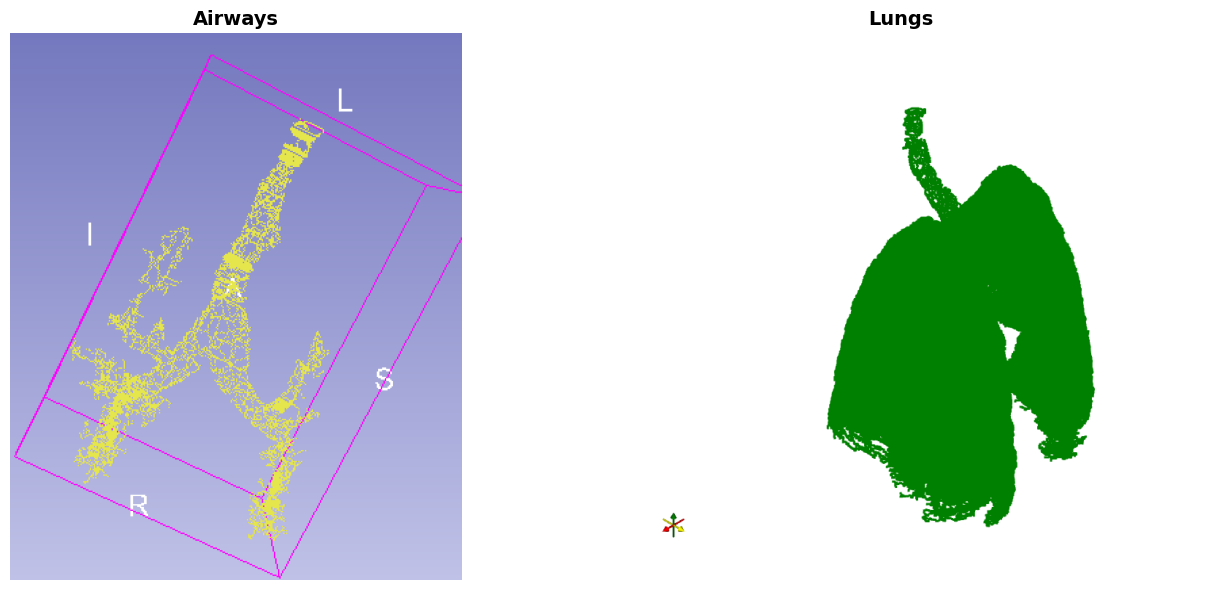

In [ ]:
def skeleton_to_points(skeleton):
    """
    Converts a skeleton mask (bool) to a list of voxel coordinates (3D points).
    """
    coords = np.argwhere(skeleton)
    return coords

def rotate_points_clockwise_90_xz(points):
    """
    Rotates points 90° clockwise in the XZ plane.
    This makes the trachea (top) appear at the top of the plot.
    """
    rotated = np.zeros_like(points)
    rotated[:, 0] = -points[:, 2] + np.max(points[:, 2])  # new X = -Z + offset
    rotated[:, 1] = points[:, 1]                          # Y unchanged
    rotated[:, 2] = points[:, 0]                          # new Z = old X
    return rotated

# Convert skeletons to 3D points
airway_points = skeleton_to_points(airway_skeleton)
lung_points = skeleton_to_points(lung_skeleton)

airway_points_rot = rotate_points_clockwise_90_xz(airway_points)
lung_points_rot = rotate_points_clockwise_90_xz(lung_points)


def safe_show(plotter, title):
    """ Safe display function for plots in Jupyter/VSCode."""
    try:
        # Open interactively in HTML
        plotter.show(title=title, jupyter_backend='html')
    except:
        print("Interactive window not available. Please try opening the VTP file in 3D Slicer.")

# 1. Visualization 1: Airways
cloud_airway = pv.PolyData(airway_points_rot)

plotter1 = pv.Plotter()
plotter1.add_mesh(cloud_airway, color="blue", point_size=3, render_points_as_spheres=True)
plotter1.add_axes()
safe_show(plotter1, "3D visualization of airway skeleton (trachea at top)")


# 2. Visualization 2: Lungs

cloud_lung = pv.PolyData(lung_points_rot)

plotter2 = pv.Plotter()
plotter2.add_mesh(cloud_lung, color="green", point_size=3, render_points_as_spheres=True)
plotter2.add_axes()
safe_show(plotter2, "3D visualization of lung skeleton (trachea at top)")

# Display airway and lung images
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Display airway image
if os.path.exists('bronchi.png'):
    airway_img = Image.open('bronchi.png')
    axes[0].imshow(airway_img)
    axes[0].set_title('Airways', fontsize=14, fontweight='bold')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'bronchi.png not found', ha='center', va='center')
    axes[0].set_title('Airways', fontsize=14, fontweight='bold')
    axes[0].axis('off')

# Display lungs image
if os.path.exists('lungs.png'):
    lungs_img = Image.open('lungs.png')
    axes[1].imshow(lungs_img)
    axes[1].set_title('Lungs', fontsize=14, fontweight='bold')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'lungs.png not found', ha='center', va='center')
    axes[1].set_title('Lungs', fontsize=14, fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

The performed visualization showed that the obtained skeleton of the bronchial tree faithfully reproduces the anatomical arrangement within the lungs. The point representation of the skeleton is entirely within the previously identified lung mask, which confirms the high quality of the segmentation and correct spatial limitation.

While working, I encountered problems with displaying interactive 3D scenes in Jupyter/VSCode and legends (label), resulting from:
- limitations of PyVista backends in the Jupyter environment (lack of support for `pythreejs` and `trame` depending on the computer and kernel),
- limited support for AMD Radeon graphics card in `vtkWin32OpenGLRenderWindow` mode.

The visualizations were displayed in **HTML** format, and if needed, they can be opened as VTP files and opened in **3D Slicer** for full interactivity.

---

###  Conclusions

Within the framework of the project, it was possible to carry out a complete process of processing computed tomography data, starting from loading DICOM files, through conversion to the Hounsfield scale, to segmentation of lungs and airways along with skeletonization and 3D visualization.

Lung segmentation proceeded without major problems, and the applied morphological operations allowed obtaining a precise mask with well-defined boundaries.

Airway segmentation turned out to be the most difficult and time-consuming stage of the project. The greatest challenge was the extraction of thin and distant branches of the bronchial tree while avoiding the inclusion of blood vessels in the mask.

However, by applying a multi-stage approach, starting from basic air segmentation, through identification of airway walls, to adding thin branches and coating around bifurcations – it was possible to obtain a satisfactory and coherent representation of the bronchial tree. The skeletonization process, in which the number of voxels was reduced from several hundred thousand to several thousand while maintaining the topology of structures, confirmed the effectiveness of the developed algorithms.

The realization of the project allowed me to gain valuable experience in processing and analyzing medical data. I learned to work with DICOM and NIfTI data, use libraries for segmentation and 3D visualization in Python, and understood the importance of accurate parameter selection for morphological algorithms. I also gained a better understanding of respiratory system anatomy, which proved crucial for proper interpretation of results. The project strengthened my skills in solving complex technical problems and showed how important systematic approach is when working on medical image processing algorithms.

---
## Bibliography

Radiopaedia – Hounsfield Unit (HU) Scale.  
https://radiopaedia.org/articles/hounsfield-units

scikit-image – for segmentation, labeling, and morphological operations.  
https://scikit-image.org/docs/stable/

scipy.ndimage – for binary operations, closing, and hole filling.  
https://docs.scipy.org/doc/scipy/tutorial/ndimage.html

nibabel – for handling medical image files in NIfTI format.  
https://nipy.org/nibabel/